In [1]:
import dtoolcore
import dtoolcore.utils as utils
import time
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import re
from dx_utils import zetta
import itertools
from itertools import permutations
import matplotlib as mpl

mpl.rcParams.update({
    "font.sans-serif": ["Arial"],
    "font.cursive": ["Arial"],
    "font.family": "serif",
    "font.serif": ["Arial"],
    "font.size": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 14,
    "svg.fonttype": "none"
})

def ret_fig_ax(rows=1, cols=1):
    fig_width_pt = 448.13095  # Replace with your document's text width
    inches_per_pt = 1 / 72.27
    fig_width_in = fig_width_pt * inches_per_pt
    fig, ax = plt.subplots(rows,cols, figsize=( fig_width_in*2, fig_width_in )) #, sharey=True)
    #ax.set_aspect('equal')
    return fig, ax

[sick:07837] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.sick.1000/jf.0/2326134784/shared_mem_cuda_pool.sick could be created.
[sick:07837] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [5]:
rootdir = os.getcwd()

# pat = r'canal_\d+\.\d+_\d+'
pat = r'\d+\.\d+'
path = rootdir+"/dtool_db/"
#print(path)
def get_data_directories(root_dir):
    data_dirs = []
    for root, dirs, files in os.walk(root_dir):
        if root.endswith('/data'):
            data_dirs.append(root)
    return data_dirs

datadir_list = get_data_directories(path)

In [6]:
len(datadir_list)

90

In [7]:
from dtoolcore import DataSet
import json

def get_height_from_dtool(dataset_uri):
    ## Dataset-level metadata
    dataset = DataSet.from_uri(dataset_uri)
    
    # Load the dataset
    dataset = DataSet.from_uri(dataset_uri)
    
    # Get the 'metadata' annotation
    metadata = dataset.get_annotation("metadata")
    
    # Print the metadata
    res = metadata[0]
    if res["p0"] ==0:
        return 1, np.ones(500)
    y = zetta(res["p0"], res["pl"], res["pg"],2,1000, num=500)
    
    return np.min(y), y

def find_matching_files(directory, pattern):
    regex = re.compile(pattern)
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if regex.search(os.path.join(root, file)):
                matching_files.append(os.path.join(root, file))
    return matching_files

def detect_segments(data, threshold):
    differences = np.abs(np.diff(data))
    discontinuities = np.where(differences > threshold)[0]
    segments = np.split(data, discontinuities + 1)
    return segments

def find_best_order(segments):
    n = len(segments)
    best_order = list(range(n))
    best_score = float('inf')
    
    for perm in itertools.permutations(range(n)):
        reordered = np.concatenate([segments[i] for i in perm])
        score = np.sum(np.abs(np.diff(reordered)))
        if score < best_score:
            best_score = score
            best_order = perm
    
    return best_order

def correct_profile(data, threshold):
    segments = detect_segments(data, threshold)
    best_order = find_best_order(segments)
    corrected = np.concatenate([segments[i] for i in best_order])
    return corrected


#print(get_height_from_dtool("/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_540.0_560.0"))

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [550.] (10, 1)
p0:  369.0378987431335  pg:  650  pl:  182.99180455931642
0.8126872934208692
100
p0:  379.152138690583  pg:  750  pl:  172.97760029303964
0.7627227427715735
100
p0:  390.2340312958634  pg:  850  pl:  162.031705132626
0.7127523430269493
101
1
100
p0:  364.1564794342562  pg:  600  pl:  187.53323491442143
0.8375897893638775
100
p0:  384.5912108641289  pg:  800  pl:  167.6080589359983
0.7377385441032134
100
p0:  396.0441978072555  pg:  900  pl:  156.23878415471927
0.6877524359911977
100
p0:  402.6024611280217  pg:  950  pl:  150.36471602289862
0.6629148055240051
100
p0:  330.0080456664468  pg:  1000  pl:  220.0070204707961
0.6374465344402618
100
p0:  374.0011979364185  pg:  700  pl:  178.1011002572193
0.7877122013517777
100


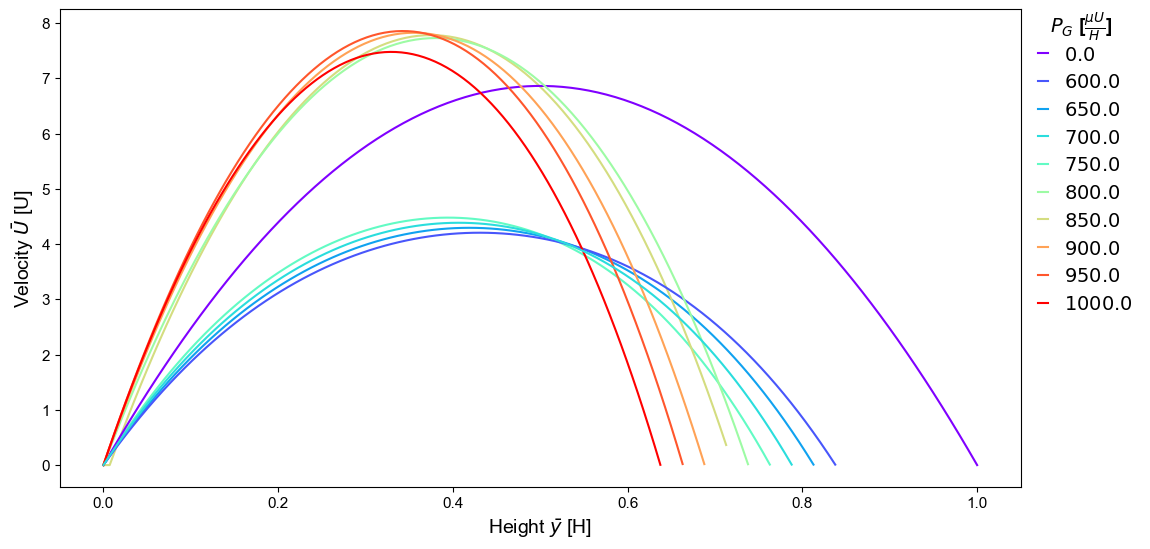

In [8]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

#from label_lines import label_lines
#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_y(pt, pt2, file, title, ax,yl='Velocity', legend=True, filename="output.pdf"):
    #fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "550.0"    
    radii_list, press_list = [], []
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)
    
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        h_max, _ = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        print(h_max)
        file_path = matching_files[0]
        u = np.loadtxt(file_path)
        #rolled_back = correct_profile(u[:,0], .4)
        print(len(u[:,0]))
        ax.plot(np.linspace(0,h_max,100),u[0:100,0], label=rf"${extracted}$")
        arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u)

    handles, labels = ax.get_legend_handles_labels()
    extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    sorted_handles, sorted_labels = zip(*sorted_pairs)

    lines = ax.get_lines()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(lines)))
    for handle, color in zip(sorted_handles, colors):
        handle.set_color(color)
    
    ax.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 0.96), loc='upper left',frameon=False,handlelength=.5)
    ax.text(1.03, 1., r'$P_G$ [$\frac{\mu U}{H}$]', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
    #plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    ax.set_ylabel(r'Velocity $\bar{U}$ [U]', fontsize=14)
    ax.set_xlabel(r'Height $\bar{y}$ [H]', fontsize=14)

    fig.savefig("fixed_velocity_pofiles.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return arr, ax

fig, ax = ret_fig_ax()
arr, ax = plot_y(pat, pat2, "/v_at_5_.*_0.72/y_at_5_.*.txt", "Pressure Distribution",ax, yl='P delta', legend=True)

In [31]:
print(arr)

[[6.86159514]
 [4.03345346]
 [4.1184142 ]
 [4.20547013]
 [4.29440723]
 [4.38556423]
 [4.4785291 ]
 [7.72857675]
 [7.78180914]
 [7.82461367]
 [7.85569648]
 [7.47785585]]


[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [550.  562.5 575.  587.5 600.  612.5 625.  637.5 650. ] (10, 9)


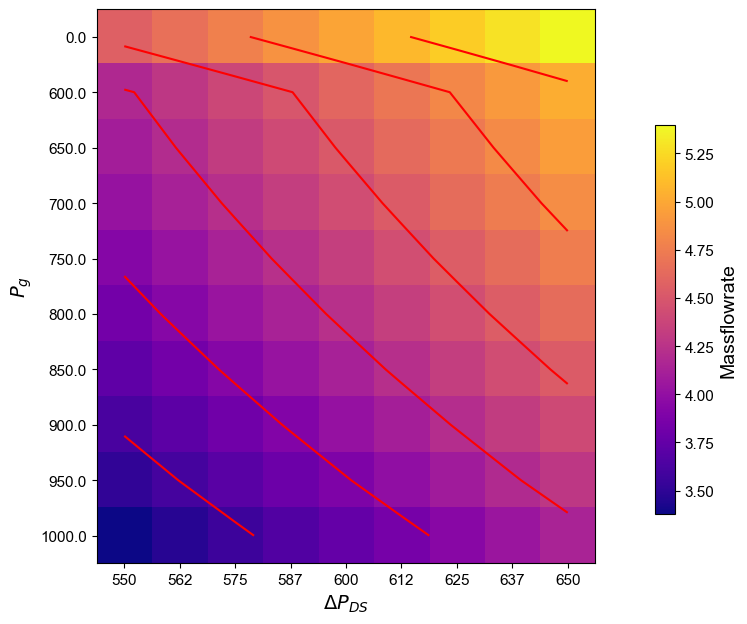

In [9]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

#from label_lines import label_lines
#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_press(pt, pt2, file, title,legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "740.0"    

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)

    
    for i in datadir_list:
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = u[0]

    #handles, labels = plt.gca().get_legend_handles_labels()
    #extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    #sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    #sorted_handles, sorted_labels = zip(*sorted_pairs)
    #plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1), loc='upper left',frameon=False)
    
    neg = ax.imshow(arr, cmap="plasma")
    ax.contour(arr, colors='red')
    #ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    ax.set_yticklabels(radii)
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7, label="Massflowrate")
    ax.set_ylabel(r'$P_g$', fontsize=14)
    ax.set_xlabel(r'$\Delta P_{DS}$', fontsize=14)

    plt.show()
    fig.savefig("massflow_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return radii, press, arr


radii, press, arr = plot_press(pat, pat2, "/flux_trapz_0.56/flux_trapz.txt", "Massflowrate", legend=True)

abs mean dist:  0.0194399172746968
linalg norm:  0.05840394026250922
[0.38962045 0.38961447 0.38960847 0.38960244 0.38959639 0.38959031
 0.38958421 0.38957809 0.38957194]


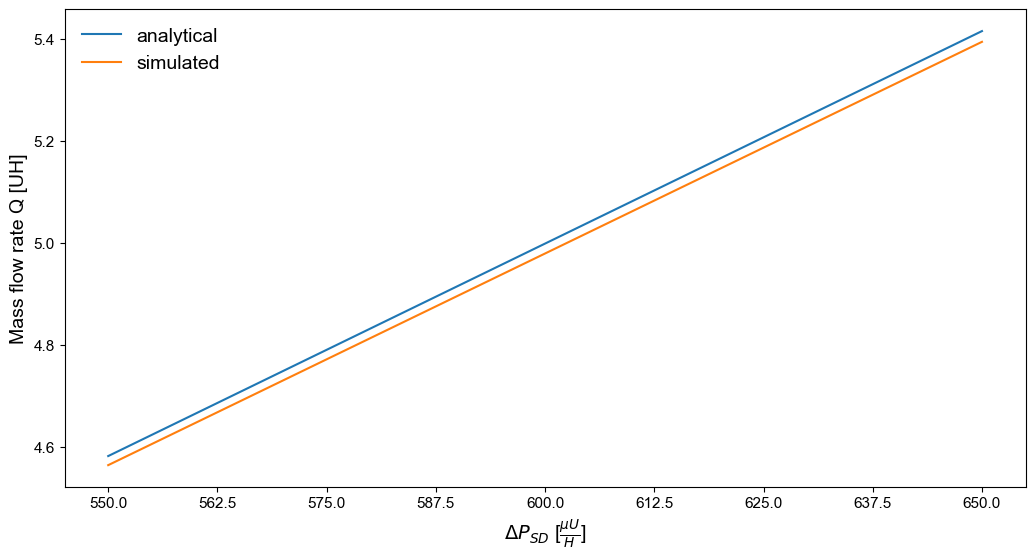

In [10]:
p_arr = np.linspace(55,65,9)
height = np.linspace(0,1,100)
fig, ax = ret_fig_ax()
def calc_velo(delta_p,y):
    delta_p = np.array(delta_p).reshape(-1, 1)
    return (1/2*delta_p*y )*(1-y)
res = calc_velo(p_arr,0.5)
res1 = calc_velo(p_arr,height)
arr2 = []
for i in res1:
    arr2.append(np.trapezoid(i, height))
ax.plot(arr2, label="analytical")
ax.plot(arr[0],label="simulated")
ax.set_xticks(np.arange(len(p_arr)))
#ax.set_xticklabels((p_arr).astype(int))
ax.set_xticklabels([f'{p*10:.1f}' for p in p_arr])
ax.set_ylabel("Mass flow rate Q [UH]")
ax.set_xlabel(r'$\Delta P_{SD}$ [$\frac{\mu U}{H}$]')
plt.legend(frameon=False)
fig.savefig("ana_vs_sim_mfl.pdf", format='pdf', dpi=300, bbox_inches='tight')
print("abs mean dist: ",np.mean( np.abs(arr[0] - arr2) ) )
print("linalg norm: ",np.linalg.norm(arr[0] - arr2))

def calculate_percentage_deviation(array1, array2):
    return 100 * (array2 - array1) / ((array2 + array1) / 2)

print(calculate_percentage_deviation(arr[0], arr2))

In [63]:
c = (25*(0.8/1000))/(7/100)
c1 = (20*(1/2000))/.03

print(c,c1)

0.2857142857142857 0.33333333333333337


In [11]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def plot_press_2(pt, pt2, file,ax, yl='Velocity', legend=True, filename="output.pdf", cmap='YlGn'):
    #fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg_l = ["_500.0","_550.0"]
    # psd = ["550.0/","650.0/"]  

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if (any(re.search(rf"{re.escape(pg_value)}(?=_|\b)", i) for pg_value in pg_l)):
            # and any(re.search(rf"{re.escape(psd_val)}", i) for psd_val in psd)):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    # print(radii, press, arr.shape)

    
    for i in datadir_list:
        if (any(re.search(rf"{re.escape(pg_value)}(?=_|\b)", i) for pg_value in pg_l)):
            # and any(re.search(rf"{re.escape(psd_val)}", i) for psd_val in psd)):
            continue
        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
             
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        if legend:
            u = np.loadtxt(i+file)
            arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u) # u[0]
        else:
            file_path = matching_files[0]
            u = np.loadtxt(file_path)
            arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u)            

    if legend:
        #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
        ax.set_ylabel(r'$P_G$ [$\frac{\mu U}{H}$]')#, fontsize=14)
        ax.set_xlabel(r'$\Delta P_{SD}$ [$\frac{\mu U}{H}$]')#, fontsize=14)
    neg = ax.imshow(arr,cmap=cmap, aspect="auto")
    ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    ax.set_yticklabels(radii)

    #plt.show()
    #fig.savefig("velocities_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return neg, radii, press, arr

def plot_y1(pt, pt2, file,ax, yl='Velocity', legend=True, filename="output.pdf", cmap='YlGn'):
    #fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg_l = ["_0.0","_700.0","_1000.0"]
    psd = ["550.0/","650.0/"]

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not (any(re.search(rf"{re.escape(pg_value)}(?=_|\b)", i) for pg_value in pg_l)):
            # and any(re.search(rf"{re.escape(psd_val)}", i) for psd_val in psd)):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)

        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    # print(radii, press, arr.shape)

    
    for i in datadir_list:
        if not (any(re.search(rf"{re.escape(pg_value)}(?=_|\b)", i) for pg_value in pg_l)):
            # and any(re.search(rf"{re.escape(psd_val)}", i) for psd_val in psd)):
            continue
        print(i)
        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        file_path = matching_files[0]
        if legend:
            u = np.loadtxt(i+file)
            arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u) # u[0]
        else:
            u = np.loadtxt(file_path)
            arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u)            

    if legend:
        #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
        ax.set_ylabel(r'$P_G$ [$\frac{\mu U}{H}$]')#, fontsize=14)
        ax.set_xlabel(r'$\Delta P_{SD}$ [$\frac{\mu U}{H}$]')#, fontsize=14)
    if not legend:
        #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
        ax.set_ylabel(r'Velocity $\bar{U}$ [U]')#, fontsize=14)
        ax.set_xlabel(r'$\Delta P_{SD}$ [$\frac{\mu U}{H}$]')
    neg = ax.plot(arr.T, label=[r' $P_G$='+str(r) for r in radii])
    #ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    #ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    #ax.set_yticklabels(radii)

    #plt.show()
    #fig.savefig("velocities_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return neg, radii, press, arr

/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_1000.0_600.0/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_700.0_575.0/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_1000.0_612.5/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_700.0_612.5/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_0.0_575.0/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_1000.0_625.0/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_0.0_550.0/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_1000.0_650.0/data
/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/rerun_memb/dtool_db/iterative_canal_1000.0_587.5/data
/home/sick/Documen

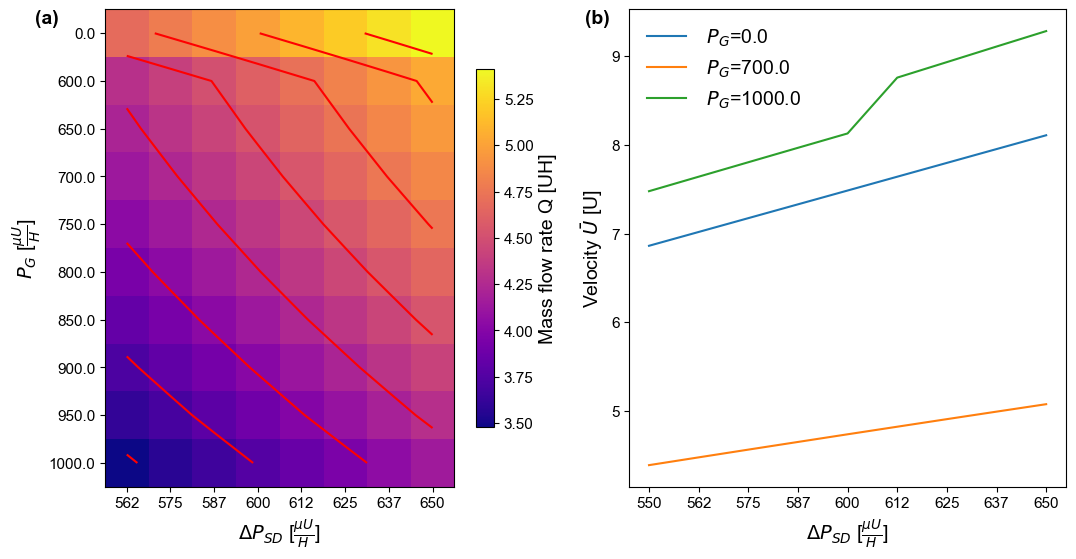

In [12]:
fig, ax = ret_fig_ax(1,2)
neg, radii, press, arr = plot_press_2(pat, pat2, "/flux_trapz_0.72/flux_trapz.txt",ax[0], yl='P delta', legend=True, cmap="plasma")
neg1, radii1, press1, arr1 = plot_y1(pat, pat2, "/y_at_5_.*_0.72/y_at_5_.*.txt",ax[1], yl='P delta', legend=False, cmap='YlGn')
#plt.tight_layout()
ax[0].text(-0.2, 1.0, '(a)', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
ax[1].text(-0.1, 1.0, '(b)', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')
ax[1].legend(frameon=False)
#fig.colorbar(neg1, ax=ax[1], location='right', anchor=(0, 0.5), shrink=0.75, label="Velocity")
fig.colorbar(neg, ax=ax[0], location='right', anchor=(0, 0.5), shrink=0.75, label="Mass flow rate Q [UH]")
fig.savefig("velocities_massflow_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [105]:
print(radii)

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.]


abs mean dist:  0.014622065566666502
linalg norm:  0.04392947129110295
0.19513310121913588 0.19517004706028274 0.19515174978453706
[[0.19517005 0.19516556 0.19516104 0.19515647 0.19515188 0.19514724
  0.19514256 0.19513785 0.1951331 ]]


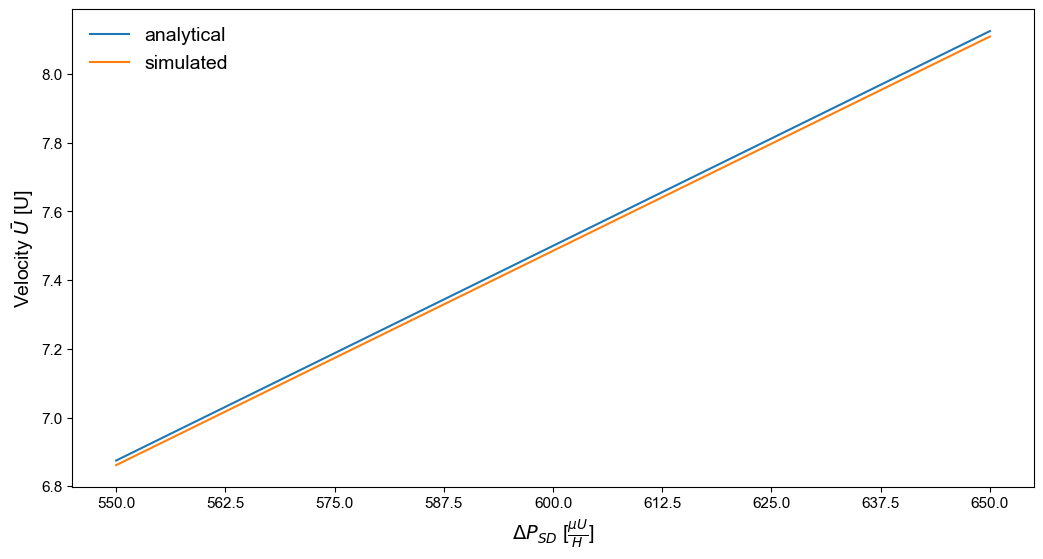

In [13]:
p_arr = np.linspace(55,65,9)
height = np.linspace(0,1,100)
fig, ax = ret_fig_ax()
def calc_velo(delta_p,y):
    delta_p = np.array(delta_p).reshape(-1, 1)
    return ((1/2*delta_p*y )*(1-y))
res = calc_velo(p_arr,0.5)
res1 = calc_velo(p_arr,height)
#arr2 = []
#for i in res1:
#    arr2.append(np.trapezoid(i, height))
ax.plot(res, label="analytical")
ax.plot(arr1[0],label="simulated")
ax.set_xticks(np.arange(len(p_arr)))
#ax.set_xticklabels((p_arr).astype(int))
ax.set_xticklabels([f'{p*10:.1f}' for p in p_arr])
ax.set_ylabel(r'Velocity $\bar{U}$ [U]')
ax.set_xlabel(r'$\Delta P_{SD}$ [$\frac{\mu U}{H}$]')
plt.legend(frameon=False)
fig.savefig("ana_vs_sim_v.pdf", format='pdf', dpi=300, bbox_inches='tight')
print("abs mean dist: ",np.mean( np.abs(arr1[0] - res.T) ))
print("linalg norm: ",np.linalg.norm(arr1[0] - res.T))

def calculate_percentage_deviation(array1, array2):
    return 100 * (array2 - array1) / ((array2 + array1) / 2)
perc = calculate_percentage_deviation(arr1[0], res.T)
print(np.min(perc), np.max(perc), np.mean(perc))
print(perc)

In [65]:
(1/2*55*.5 )*(1-.5)

6.875

In [152]:
#plt.plot(arr1.T)
#print(arr1.T)
n = arr1[0]-res
print(arr1[0], res.T)

[6.86159514 7.0175408  7.17348647 7.32943217 7.48537788 7.6413236
 7.79726935 7.95321511 8.10916089] [[6.875   7.03125 7.1875  7.34375 7.5     7.65625 7.8125  7.96875 8.125  ]]


In [86]:
a,b,c,d = 5.82, 5.98, 6.1,6.23
lala = [0.81,0.76,0.88,0.71,1,0.83,0.73,0.86,0.68,0.66,0.63,0.78]
arr.T.shape
press.shape
print(press)

[562.5 575.  587.5 600.  612.5 625.  637.5 650. ]


In [15]:
max_h = [0.81,0.76,0.88,0.71,1,0.83,0.73,0.86,0.68,0.66,0.63,0.78]
#[0.78,0.71,0.66,0.76,0.68,1,0.73,0.86,0.83,0.81]
max_h = np.abs(np.sort(max_h)[::-1]-1)

In [16]:
max_h_formatted = np.array([f'{x:.2f}' for x in max_h])
mask = np.ones(len(max_h_formatted), dtype=bool)
mask[[1,2]] = False
max_h_formatted[mask]


array(['0.00', '0.17', '0.19', '0.22', '0.24', '0.27', '0.29', '0.32',
       '0.34', '0.37'], dtype='<U4')

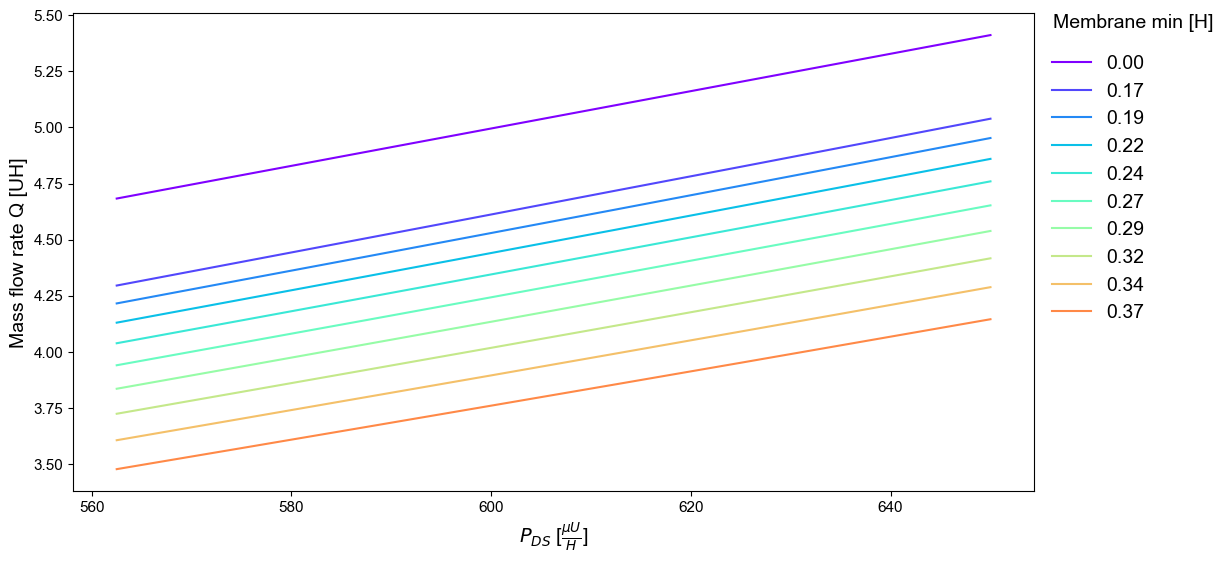

In [17]:
fig, ax =ret_fig_ax()
mask = np.ones(len(max_h_formatted), dtype=bool)
mask[[1,2]] = False
lines = ax.plot(press, arr.T, label=max_h_formatted[mask])
ax.set_ylabel("Mass flow rate Q [UH]")
#plt.gca().set_yticks(np.arange(len(radii)))
#plt.gca().set_yticklabels((radii).astype(int))
ax.set_xlabel(r'$P_{DS}$ [$\frac{\mu U}{H}$]')
colors = plt.cm.rainbow(np.linspace(0, 1, max_h.size))
for line, color in zip(lines, colors):
    line.set_color(color)

ax.text(1.02, 1., 'Membrane min [H]', transform=ax.transAxes, fontsize=14, va='top')
ax.legend(frameon=False,bbox_to_anchor=(1.0, .95), loc='upper left')
fig = plt.gcf()
fig.savefig("mass_flow_lin_55-65.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [171]:
arr.T[:,0]

array([4.39161767, 4.49142728, 4.59123691, 4.69104654, 4.79085617,
       4.89066581, 4.99047546, 5.09028511, 5.19009477])

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [650.] (10, 1)
p0:  442.1310344291081  pg:  750  pl:  210.5068667827712
0.7877217463770052
p0:  461.37703114950557  pg:  900  pl:  191.63367693487146
0.7128137431803596
p0:  390.0097110213829  pg:  1000  pl:  260.0084020128954
0.6624189863134662
p0:  448.3242940653308  pg:  800  pl:  204.49077224177444
0.762769537908099
p0:  469.0629547403219  pg:  950  pl:  184.99957849476056
0.6880671913336041
1
p0:  454.777333205048  pg:  850  pl:  198.15668607281532
0.7377987352081419
p0:  425.05138251520884  pg:  600  pl:  226.83008055161005
0.8624764356295649
p0:  430.56248191710506  pg:  650  pl:  221.75135252807166
0.8376137395371384
p0:  436.51205923731743  pg:  700  pl:  216.35649573717737
0.8127691232916829
[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [550.] (10, 1)
p0:  369.0378987431335  pg:  650  pl:  182.99180455931642
0.8126872934208692
100
p0:  379.152138690583  pg:  750  pl:  172.97760029303964
0.7627227427

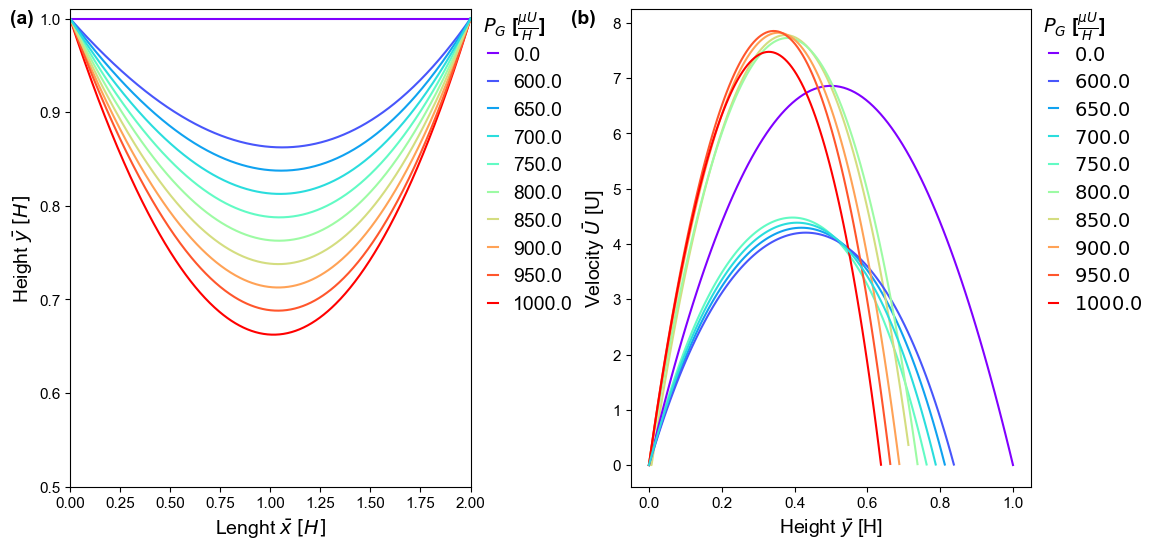

In [18]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_ymax(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax(1,2)
    plt.subplots_adjust(wspace=.4)
    pg = "650.0"
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)

    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        h_max, y = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        print(h_max)
        ax[0].plot(np.linspace(0,2,500),y, label=extracted)
    
    handles, labels = ax[0].get_legend_handles_labels()
    extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    sorted_handles, sorted_labels = zip(*sorted_pairs)

    lines = ax[0].get_lines()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(lines)))
    for handle, color in zip(sorted_handles, colors):
        handle.set_color(color)
    ax[0].legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 0.96), loc='upper left',frameon=False,handlelength=.5)

    ax[0].set_ylabel(r'Height $\bar{y}$ $[H]$', fontsize=14)
    ax[0].set_xlabel(r'Lenght $\bar{x}$ $[H]$', fontsize=14)
    ax[0].set_ylim(0.5,1.01)
    ax[0].set_xlim(0,2)

    ax[0].text(1.03, 1., r'$P_G$ [$\frac{\mu U}{H}$]', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
    ax[0].text(-0.15, 1., '(a)', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
    ax[1].text(-0.15, 1., '(b)', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')
    return radii, press, arr, ax


radii, press, arr, ax = plot_ymax(pat, pat2, "/y_at_5_.*_0.32/y_at_5_.*.txt", r"Velocity at different $P_g$", yl='P delta', legend=True)
arr2, ax[1] = plot_y(pat, pat2, "/v_at_5_.*_0.32/y_at_5_.*.txt", "Pressure Distribution",ax[1], yl='P delta', legend=True)
#ax[0].text(-0.15, 1.1, '(a)', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
#ax[1].text(-0.15, 1.1, '(b)', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')

fig = ax[0].get_figure()
fig.savefig("y_velo.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [137]:
print(arr[2,:])

[0.86240897 0.86552844 0.86866441 0.87174965 0.87482472 0.11252047
 0.11794448 0.10003085 0.11670419]


p0:  369.0378987431335  pg:  650  pl:  182.99180455931642
p0:  379.152138690583  pg:  750  pl:  172.97760029303964
p0:  390.2340312958634  pg:  850  pl:  162.031705132626
p0:  364.1564794342562  pg:  600  pl:  187.53323491442143
p0:  384.5912108641289  pg:  800  pl:  167.6080589359983
p0:  396.0441978072555  pg:  900  pl:  156.23878415471927
p0:  402.6024611280217  pg:  950  pl:  150.36471602289862
p0:  330.0080456664468  pg:  1000  pl:  220.0070204707961
p0:  374.0011979364185  pg:  700  pl:  178.1011002572193


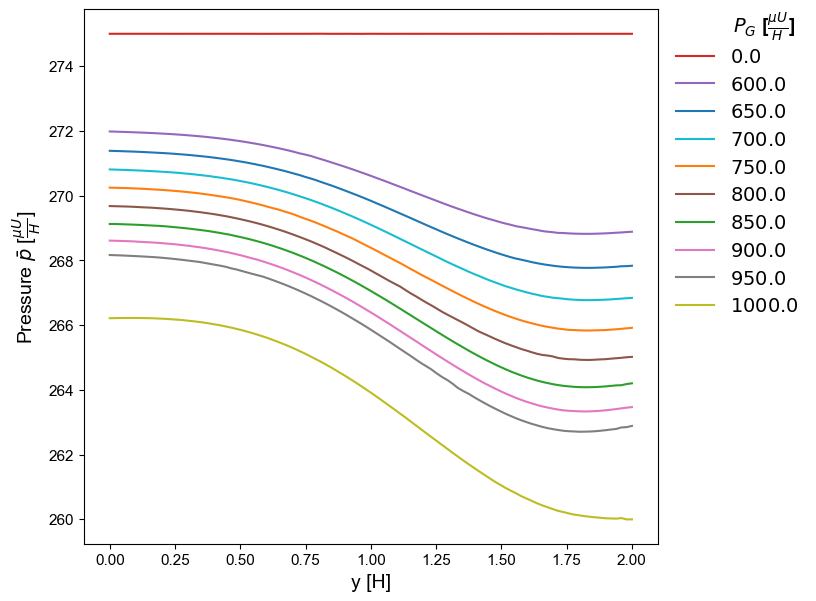

In [21]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

#from label_lines import label_lines
#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_prs(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.set_title(title)
    pg = "550.0"    
    
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        #directory = os.path.dirname(i)
        #file_pattern = os.path.basename(file)
        #matching_files = find_matching_files(directory, file_pattern)
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        h_max, _ = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        #file_path = matching_files[0]
        u = np.loadtxt(i+file)
        #rolled_back = correct_profile(u[:,0], .4)
        ax.plot(np.linspace(0,2,u.size),u, label=rf"${extracted}$")

    handles, labels = plt.gca().get_legend_handles_labels()
    extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, .96), loc='upper left',frameon=False)
    
    ax.text(1.13, 1., r'$P_G$ [$\frac{\mu U}{H}$]', transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    ax.set_ylabel(r'Pressure $\bar{p}$ [$\frac{\mu U}{H}$]', fontsize=14)
    ax.set_xlabel(r'y [H]', fontsize=14)

    plt.show()
    fig.savefig("pressure_profiles.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_prs(pat, pat2, "/p_at_5_0.72/p_at_5.txt", "Pressure Distribution", yl='P delta', legend=True)

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [550.  562.5 575.  587.5 600.  612.5 625.  637.5 650. ] (10, 9)
p0:  410.89935124116613  pg:  750  pl:  191.55696722793647
p0:  360.00886998002863  pg:  1000  pl:  240.0077068412762
p0:  369.0378987431335  pg:  650  pl:  182.99180455931642
p0:  407.60220021852496  pg:  650  pl:  207.11260046790755
p0:  402.95828110963555  pg:  750  pl:  186.87681756774504
p0:  430.77125060823664  pg:  850  pl:  184.4126158234783
p0:  376.8209224620919  pg:  650  pl:  187.7941920668458
p0:  422.7160916876807  pg:  850  pl:  179.8803911661392
p0:  379.152138690583  pg:  750  pl:  172.97760029303964
p0:  389.61698442457816  pg:  700  pl:  187.48862891496609
p0:  398.38578008873117  pg:  850  pl:  166.4558566916793
p0:  367.5090786598389  pg:  1000  pl:  245.00787980103675
p0:  400.1613252520446  pg:  650  pl:  202.23721669135608
p0:  424.6606088212215  pg:  800  pl:  190.48334372471413
p0:  442.1310344291081  pg:  750  pl:  210.5068667827712
p0

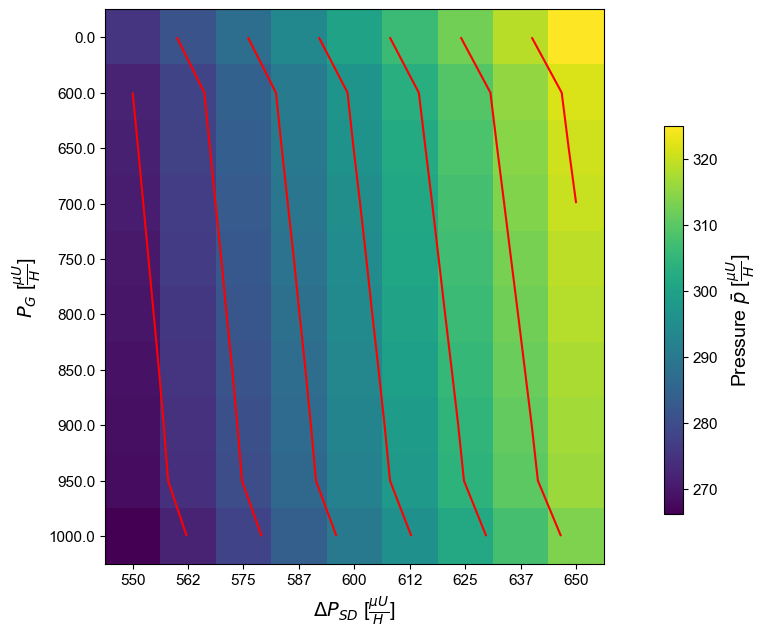

In [22]:

def plot_press2(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "740.0"    

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        #if not re.search(r'' + re.escape(pg) + r'\/data$', i):
        #    continue
        
        #print(i)
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)

    
    for i in datadir_list:
        #if not re.search(r'' + re.escape(pg) + r'\/data$', i):
        #    continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        h_max = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        file_path = matching_files[0]
        u = np.loadtxt(file_path)
        arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u)

    #handles, labels = plt.gca().get_legend_handles_labels()
    #extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    #sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    #sorted_handles, sorted_labels = zip(*sorted_pairs)
    #plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1), loc='upper left',frameon=False)
    
    neg = ax.imshow(arr)
    ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    ax.set_yticklabels(radii)
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7, label=r'Pressure $\bar{p}$ [$\frac{\mu U}{H}$]')
    ax.set_ylabel(r'$P_G$ [$\frac{\mu U}{H}$]', fontsize=14)
    ax.set_xlabel(r'$\Delta P_{SD}$ [$\frac{\mu U}{H}$]', fontsize=14)

    plt.show()
    fig.savefig("press_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return radii, press, arr

radii, press, arr = plot_press2(pat, pat2, "/p_at_5_0.32/p_at_5.txt", r"Velocity at different $P_g$", yl='P delta', legend=True)

In [115]:
arr

array([[275.00745559, 281.25763068, 287.50780603, 293.75798164,
        300.00815751, 306.25833364, 312.50851002, 318.75868667,
        325.00886358],
       [274.27457338, 280.52544342, 286.77057866, 293.0145862 ,
        299.24672114, 305.49134514, 311.7408207 , 317.98152347,
        324.2371575 ],
       [274.09209664, 280.33638777, 286.56420548, 292.81023971,
        299.04873248, 305.27855965, 311.52227398, 317.75218803,
        324.00152744],
       [273.91926909, 280.16656277, 286.37525875, 292.5979064 ,
        298.82247979, 305.047974  , 311.28191187, 317.5084    ,
        323.73693215],
       [273.739041  , 279.93819812, 286.15826333, 292.3873182 ,
        298.60175592, 304.82162954, 311.05555657, 317.26781172,
        323.51232059],
       [273.56562746, 279.77650917, 285.98380174, 292.19271003,
        298.38363635, 304.60783344, 310.82226368, 317.03509235,
        323.23546806],
       [273.36634044, 279.56428396, 285.7633916 , 291.95745893,
        298.16169255, 304.3971